In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt

In [7]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
FICHERO_RESEÑAS = 'GPT_transformer/data/reviews_random_forest.csv'

In [9]:
reviews = pd.read_csv(FICHERO_RESEÑAS)

In [10]:
reviews.head()

,reseñas,IA,longitud,longitud_promedio,palabras_unicas,signos_de_puntuación,frecuencia_pronombres,variedad_lexica,entropia_lexica,expresiones,tfidf,palabras_complejas,tecnicismos,polaridad,subjetividad,coherencia
0,Necesitaba un nuevo movil y me decidí por este...,0,297,4.066667,0.733333,6,0,0.733333,5.267482,0,5.640761e-02,3,0,0.0,0.0,0.920000
1,Está en perfectas condiciones la batería al 10...,0,99,5.375000,1.000000,2,0,1.000000,4.000000,0,5.551115e-17,2,0,0.0,0.0,1.000000
2,Me llegó ayer el iPhone en perfectas condicion...,0,436,4.402439,0.695122,7,0,0.707317,5.710972,0,5.749596e-02,5,0,0.0,0.0,0.857143
3,Compré un iPhone 12 a este vendedor y hace un...,0,657,4.124031,0.581395,10,1,0.604651,5.880116,0,7.866846e-02,5,0,0.0,0.0,0.823529
4,Soy usuario de IPhone desde el principio. Teng...,0,596,4.109244,0.638655,11,0,0.655462,5.953860,0,7.357145e-02,4,0,0.0,0.0,0.953488


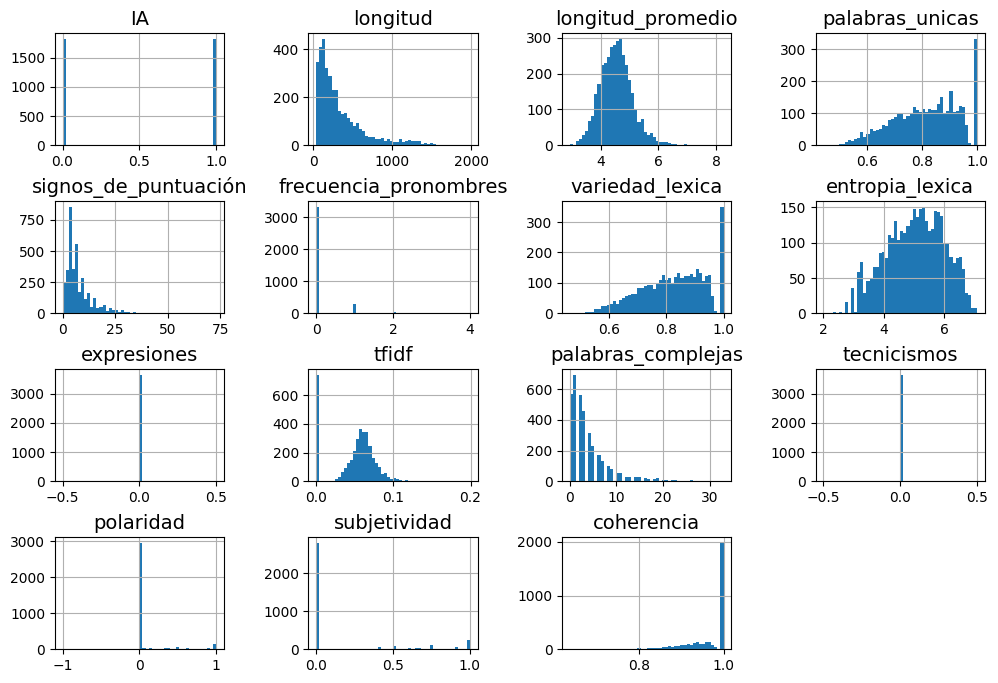

In [11]:
# Parece que no ha cambiado demasiado, quitemos algunas columnas.
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

reviews.hist(bins=50, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
#save_fig("attribute_histogram_plots")  # extra code
plt.show()

In [12]:
# Hacemos un grid search para ver los mejores posibles hiperparámetros
X = reviews.drop(columns=['reseñas', 'IA'])
y = reviews[['IA']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo
rf = RandomForestClassifier(random_state=42)

# Definir el espacio de parámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': range(2, 10),
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Ejecutar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y el mejor modelo
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluar el mejor modelo en el conjunto de prueba
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Mejores hiperparámetros: {best_params}")
print(f"Exactitud en el conjunto de prueba: {accuracy:.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
157 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}
Exactitud en el conjunto de prueba: 0.8000


In [13]:
# Mejores hiperparámetros: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}
# Exactitud en el conjunto de prueba: 0.8000
print(best_rf)
print(best_params)
grid_search

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=200,
                       random_state=42)
{'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 10),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [14]:
def obtener_bosque(X, y, criterion, max_depth, max_features, n_estimators, test_size=0.2): 
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)
    rnd_clf = RandomForestClassifier(random_state=42, criterion=criterion, max_depth=max_depth, 
                                     max_features=max_features, n_estimators=n_estimators)
    rnd_clf.fit(X_train, y_train)
    y_pred_rf = rnd_clf.predict(X_test)

    # Calcular métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_rf)
    precision = precision_score(y_test, y_pred_rf)
    recall = recall_score(y_test, y_pred_rf)
    f1 = f1_score(y_test, y_pred_rf)
    roc_auc = roc_auc_score(y_test, y_pred_rf)
    conf_matrix = confusion_matrix(y_test, y_pred_rf)
    classification_rep = classification_report(y_test, y_pred_rf)

    # Imprimir resultados
    print(f"Modelo con test_size={test_size}\n")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}") # mide la capacidad del modelo para distinguir entre clases. Un valor de 0.8074 sugiere que el modelo tiene un buen rendimiento discriminatorio.
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)
    return rnd_clf

In [15]:
X = reviews.drop(columns=['reseñas', 'IA'])
y = reviews[['IA']]

rf = obtener_bosque(X=X, y=y, criterion='entropy', max_depth=9, max_features='sqrt', n_estimators=200, test_size=0.2)

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo con test_size=0.2

Accuracy: 0.8000
Precision: 0.7580
Recall: 0.8382
F1 Score: 0.7961
ROC-AUC: 0.8025
Confusion Matrix:
[[299  91]
 [ 55 285]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       390
           1       0.76      0.84      0.80       340

    accuracy                           0.80       730
   macro avg       0.80      0.80      0.80       730
weighted avg       0.80      0.80      0.80       730



In [16]:
rf

RandomForestClassifier(criterion='entropy', max_depth=9, n_estimators=200,
                       random_state=42)

In [17]:
# El modelo clasifica correctamente el 80 % de las muestras

In [18]:
# En el caso de la precision el modelo esta diciendo que con un 76.76 % de probabilidad acierta cada vez que dice 1, es decir que de todos los que
# dice que son 1 son 1, y el resto dice que son 1 pero eran 0

In [19]:
# Y en cuanto al recall tenemos un 83.53 % que es basicamente que mi modelo sobre todos los que son positivos, es decir sobre todos los unos
# (ia) acierta el 83.53 % y en el resto de 1 dice que son ceros pero eran 1

In [20]:
# Con esto podemos determinar que el modelo tiende mas a encontrar fallos en los humanos que perfecciones que hace la ia, se equivoca menos diciendo
# que eran

In [21]:
# ha fallado menos diciendo que eran 0 aun siendo 1, por lo que falla menos en determinar si era una persona

In [22]:
'''
    Confusion Matrix:
[[TN  FP]
 [ FN TP]]
'''

'\n    Confusion Matrix:\n[[TN  FP]\n [ FN TP]]\n'

In [23]:
# Con esto podemos concluir que nuestro modelo acierta ligeramente mejor y se esquivoca menos en los que son humanos, y en los que ha escrito
# la ia se suelen colar mas, la diferencia es muy ligera

In [24]:
probar_test_size = [0.2, 0.4, 0.6, 0.8]
for i in probar_test_size:
    obtener_bosque(X=X, y=y, criterion='entropy', max_depth=9, max_features='sqrt', n_estimators=200, test_size=i)

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo con test_size=0.2

Accuracy: 0.8000
Precision: 0.7580
Recall: 0.8382
F1 Score: 0.7961
ROC-AUC: 0.8025
Confusion Matrix:
[[299  91]
 [ 55 285]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       390
           1       0.76      0.84      0.80       340

    accuracy                           0.80       730
   macro avg       0.80      0.80      0.80       730
weighted avg       0.80      0.80      0.80       730



c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo con test_size=0.4

Accuracy: 0.8041
Precision: 0.7791
Recall: 0.8359
F1 Score: 0.8065
ROC-AUC: 0.8048
Confusion Matrix:
[[578 169]
 [117 596]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       747
           1       0.78      0.84      0.81       713

    accuracy                           0.80      1460
   macro avg       0.81      0.80      0.80      1460
weighted avg       0.81      0.80      0.80      1460



c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo con test_size=0.6

Accuracy: 0.8081
Precision: 0.7878
Recall: 0.8373
F1 Score: 0.8118
ROC-AUC: 0.8085
Confusion Matrix:
[[863 244]
 [176 906]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1107
           1       0.79      0.84      0.81      1082

    accuracy                           0.81      2189
   macro avg       0.81      0.81      0.81      2189
weighted avg       0.81      0.81      0.81      2189



c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Modelo con test_size=0.8

Accuracy: 0.8010
Precision: 0.7730
Recall: 0.8520
F1 Score: 0.8106
ROC-AUC: 0.8010
Confusion Matrix:
[[1095  365]
 [ 216 1243]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1460
           1       0.77      0.85      0.81      1459

    accuracy                           0.80      2919
   macro avg       0.80      0.80      0.80      2919
weighted avg       0.80      0.80      0.80      2919



In [25]:
# Como podemos observar no hay un gran ccambio en las metricas cuando cambiamos el tamaño del test. Esto es 
# una señal de que tu modelo ha capturado bien los patrones de los datos y está evitando tanto el sobreajuste como el subajuste.

# Indicando Estabilidad, Suficiencia de datos, Buena distribución de datos y modelo solido

In [26]:
# aunque para validar un poco mas el modelo podemos usar cross validation
scores = cross_val_score(rf, X, y, cv=10)  # 10-fold cross-validation
print(f"Puntajes de validación cruzada: {scores}")
print(f"Media de puntajes: {scores.mean()}")
print(f"Desviación estándar de los puntajes: {scores.std()}")

c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pabma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConvers

Puntajes de validación cruzada: [0.80273973 0.76712329 0.82191781 0.81369863 0.82465753 0.83835616
 0.82191781 0.7890411  0.82692308 0.82142857]
Media de puntajes: 0.8127803703146169
Desviación estándar de los puntajes: 0.0199668761338871


In [27]:
# La validación cruzada proporciona una evaluación más robusta del rendimiento del modelo al dividir los datos en múltiples
# subconjuntos de entrenamiento y prueba, y promediando los resultados.

In [28]:
# La baja desviación estándar (0.0227) sugiere que tu modelo tiene un rendimiento consistente en diferentes subconjuntos de los datos. 
# Esto es un buen indicador de que tu modelo está generalizando bien y 
# no es demasiado sensible a cambios en los datos de entrenamiento y prueba, esto indica que no hay overfittin (el modelo es demasiado complejo
# para los datos y captura mucho ruido)

In [29]:
# Una precisión promedio de 80.9% es generalmente buena, dependiendo del contexto y la naturaleza del problema que estás resolviendo.

In [30]:
# La combinación de una alta media de puntajes y una baja desviación estándar sugiere que tu modelo es robusto y confiable.

In [31]:
features_names_list = list(X.columns.values)
features_names_list

['longitud',
 'longitud_promedio',
 'palabras_unicas',
 'signos_de_puntuación',
 'frecuencia_pronombres',
 'variedad_lexica',
 'entropia_lexica',
 'expresiones',
 'tfidf',
 'palabras_complejas',
 'tecnicismos',
 'polaridad',
 'subjetividad',
 'coherencia']

In [32]:
from sklearn.tree import export_graphviz

export_graphviz(
        rf.estimators_[0],
        out_file=str(IMAGES_PATH / "example_tree.dot"),
        feature_names=features_names_list,
        class_names=["Green", "Blue"],
        rounded=True,
        filled=True
    )

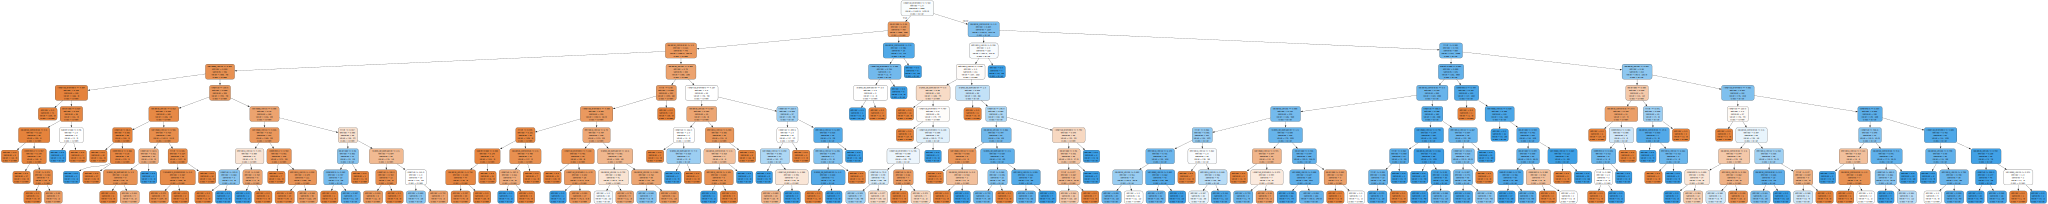

In [33]:
from graphviz import Source

Source.from_file(str(IMAGES_PATH/"example_tree.dot"))

In [34]:
# Entender que cojones es la entropia en el arbol, quizas es demasiado complejo el modelo?, probar con los diferentes max_depth

In [35]:
# La entropía es una medida de la impureza o la incertidumbre en un conjunto de datos. 
# En el contexto de los árboles de decisión y los bosques aleatorios (Random Forest), 
# la entropía se utiliza para medir la cantidad de desorden o la cantidad de información contenida en un conjunto de datos.
# La entropía se calcula utilizando la fórmula de la teoría de la información de Shannon:´
# es basicamente un sumatorio del producto entre la proporcion de instancias que pertenecen a la clase del nodo por el log en base 2 de esa proporcion

In [36]:
# Mientras que el gini se enfoca en minimizar la probabilidad de una clasificación incorrecta al azar

In [37]:
# En cuanto a la complejidad del modelo podemos hablar del tema del max depth que igual nos podría parecer algo desproporcionado, sobre todo
# cuando bajarlo no supone un gran cambio en las metricas, sin embargo un depth bajo provoca una tendencia a generalizar en el modelo,
# y en nuestro caso nos interesa obtener detalles precisos ya que lo que estamos intentando precedir podriamos considerarlo como algo complejo,
# ya que determinar si un texto corto - mediano lo ha hecho una ia o no, no es algo que se pueda generalizar. 
# En conclusión aunque parezca que un nivel alto de depth complejiza el modelo, nos podría venir mejor ya que en terminos generales,
# podra capturar mas los detalles.

In [38]:
# Tanto los resultados del gridSearch como los resultados del cross validation indican que el modelo es estable por lo que no deberiamos preocuparnos
# por su complejidad, parece que esta en un buen punto entre un sobreajuste y un subajuste porque ambos tienen medias altas y desviaciones bajas